In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import random 
import shutil
import warnings 
import numpy as np
%matplotlib inline
import pandas as pd 
import seaborn as sns 
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot  as plt
warnings.filterwarnings("ignore")
from keras.optimizers import Adam
from tensorflow.keras import Model
from keras.models import Sequential 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten , Dense , Conv2D, Dropout , MaxPooling2D 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense

ModuleNotFoundError: No module named 'matplotlib'

## Data Paths , And Dir 

In [ ]:
Dataset_path = 'Student-engagement-dataset'
Target_path = 'Student-engagement-Dataset'

# create train/test/validation dirs
Train_dir = os.path.join(Target_path,'train')
valid_dir = os.path.join(Target_path,'validation')
Test_dir = os.path.join(Target_path,'test')

os.makedirs(Target_path,exist_ok = True)
os.makedirs(Train_dir,exist_ok=True)
os.makedirs(valid_dir,exist_ok=True)
os.makedirs(Test_dir,exist_ok=True)

## Data Loader 

In [ ]:
img_size = (256,256)

image_paths = []
labels = []
preprocced_image_paths = [] 
preprocced_image_paths_test=[]   
for path in os.listdir(Dataset_path) :                                         #label = eng , diseng
        main_classes_dir = os.path.join(Dataset_path,path)                          #print(main_classes_dir)
        for main_path in os.listdir(main_classes_dir):                             #print labels=fursted,bored,drowsy,confused,..
            
            sub_classes_dir = os.path.join(main_classes_dir,main_path)
            
            img_count = len(os.listdir(sub_classes_dir)) 
            test_img_count = int(0.2*img_count)
            train_img_count = img_count - test_img_count
            
            target_train_dir = os.path.join(Train_dir,main_path)
            target_test_dir = os.path.join(Test_dir,main_path)
            target_validation_dir = os.path.join(valid_dir,main_path)
        
            os.makedirs(target_train_dir,exist_ok =True)                          #files with labels 
            os.makedirs(target_test_dir,exist_ok=True)
            os.makedirs(target_validation_dir,exist_ok=True)
            for sub_main_path in os.listdir(sub_classes_dir):
                
                  image_path = os.path.join(sub_classes_dir,sub_main_path)
                  image_paths.append(image_path)
                  labels.append(main_path)
                
                                                                                #Resize ,normlization 
                  img = cv2.imread(image_path)
                  img = cv2.resize(img,img_size)
#                   img = img / 255
            
                                                                                #Split train,test images 
                  
            
                  if len(os.listdir(target_test_dir)) != test_img_count:
                        cv2.imwrite(os.path.join(target_test_dir, sub_main_path), img)
                        preprocced_image_paths.append(os.path.join(target_test_dir,sub_main_path))
#                         preprocced_image_paths_test.append(os.path.join(target_test_dir,sub_main_path))
                  else:
                        cv2.imwrite(os.path.join(target_train_dir,sub_main_path),img )
                        preprocced_image_paths.append(os.path.join(target_train_dir,sub_main_path))
                      
    

In [ ]:
print(image_paths[0:2])

['Student-engagement-dataset\\Engaged\\confused\\0020.jpg', 'Student-engagement-dataset\\Engaged\\confused\\0021.jpg']


### img counts 

In [ ]:
img_count = len(image_paths)
test_img_count = int(0.2*img_count)
train_img_count = img_count - test_img_count

print("img_count",img_count)
print("test_no", test_img_count)
print("train_img_no",train_img_count)

img_count 5939
test_no 1187
train_img_no 4752


## Create Dataframe from Dataset

In [ ]:
dataset = pd.DataFrame()
dataset["label"],dataset["image"],dataset['preproccesd_image']= labels,image_paths,preprocced_image_paths
dataset = dataset.sample(frac=1).reset_index(drop=True)
print(dataset["image"][3])
print(dataset['preproccesd_image'][3])
dataset.head()

Student-engagement-dataset\Not engaged\drowsy\0059.jpg
Student-engagement-Dataset\test\drowsy\0059.jpg


label                                              image  \
0         bored    Student-engagement-dataset\train\bored\0347.jpg   
1  Looking Away  Student-engagement-dataset\Not engaged\Looking...   
2  Looking Away  Student-engagement-dataset\test\Looking Away\0...   
3        drowsy  Student-engagement-dataset\Not engaged\drowsy\...   
4  Looking Away  Student-engagement-dataset\Not engaged\Looking...   

                                   preproccesd_image  
0     Student-engagement-Dataset\test\bored\0347.jpg  
1  Student-engagement-Dataset\test\Looking Away\0...  
2  Student-engagement-Dataset\test\Looking Away\0...  
3    Student-engagement-Dataset\test\drowsy\0059.jpg  
4  Student-engagement-Dataset\test\Looking Away\0...

## Explore the Data :


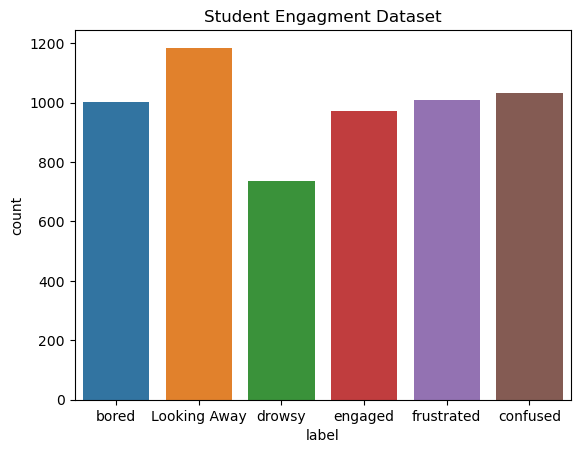

In [ ]:
sns.countplot(x=dataset["label"]);
plt.title("Student Engagment Dataset") ;

In [ ]:
dataset["label"].value_counts()

Looking Away    1185
confused        1034
frustrated      1008
bored           1003
engaged          972
drowsy           737
Name: label, dtype: int64

## Display grid of Pic (befor proccessing ) :

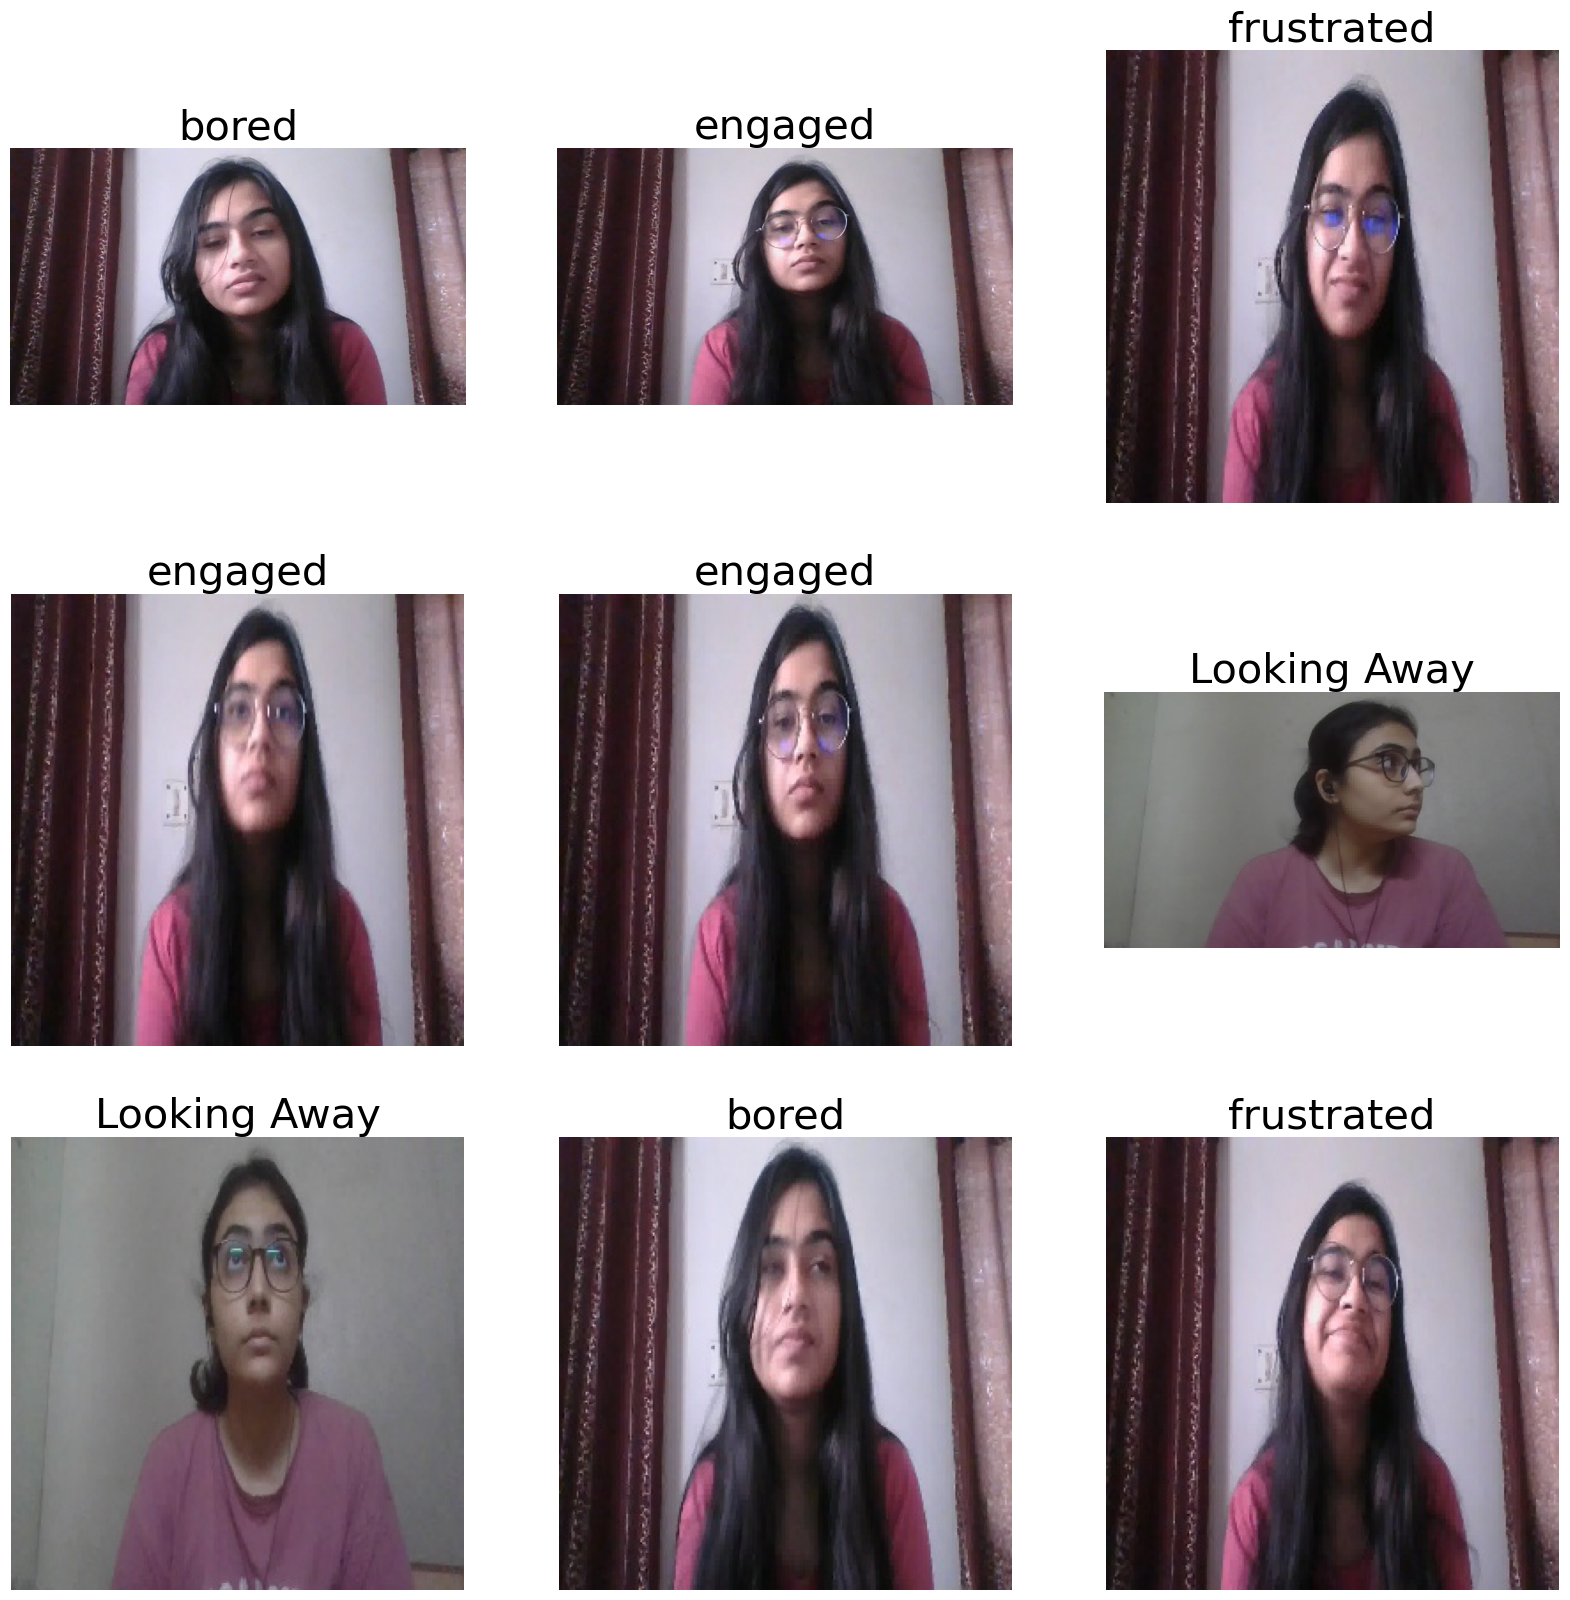

In [ ]:
from PIL import Image
plt.figure(figsize=(20,20))
dataset_ = pd.DataFrame(zip(dataset['label'] , dataset['image']))
files=dataset_.iloc[0:9]

for index,label,file_path in files.itertuples():
    #print(index,file_path,label)
    plt.subplot(3,3,index+1)
    img=load_img(file_path)
      
    img=np.array(img)
    plt.imshow(img)
    plt.title(label,fontsize=30)
    plt.axis('off')


## Display Grid of Pic (After Resizing) : 


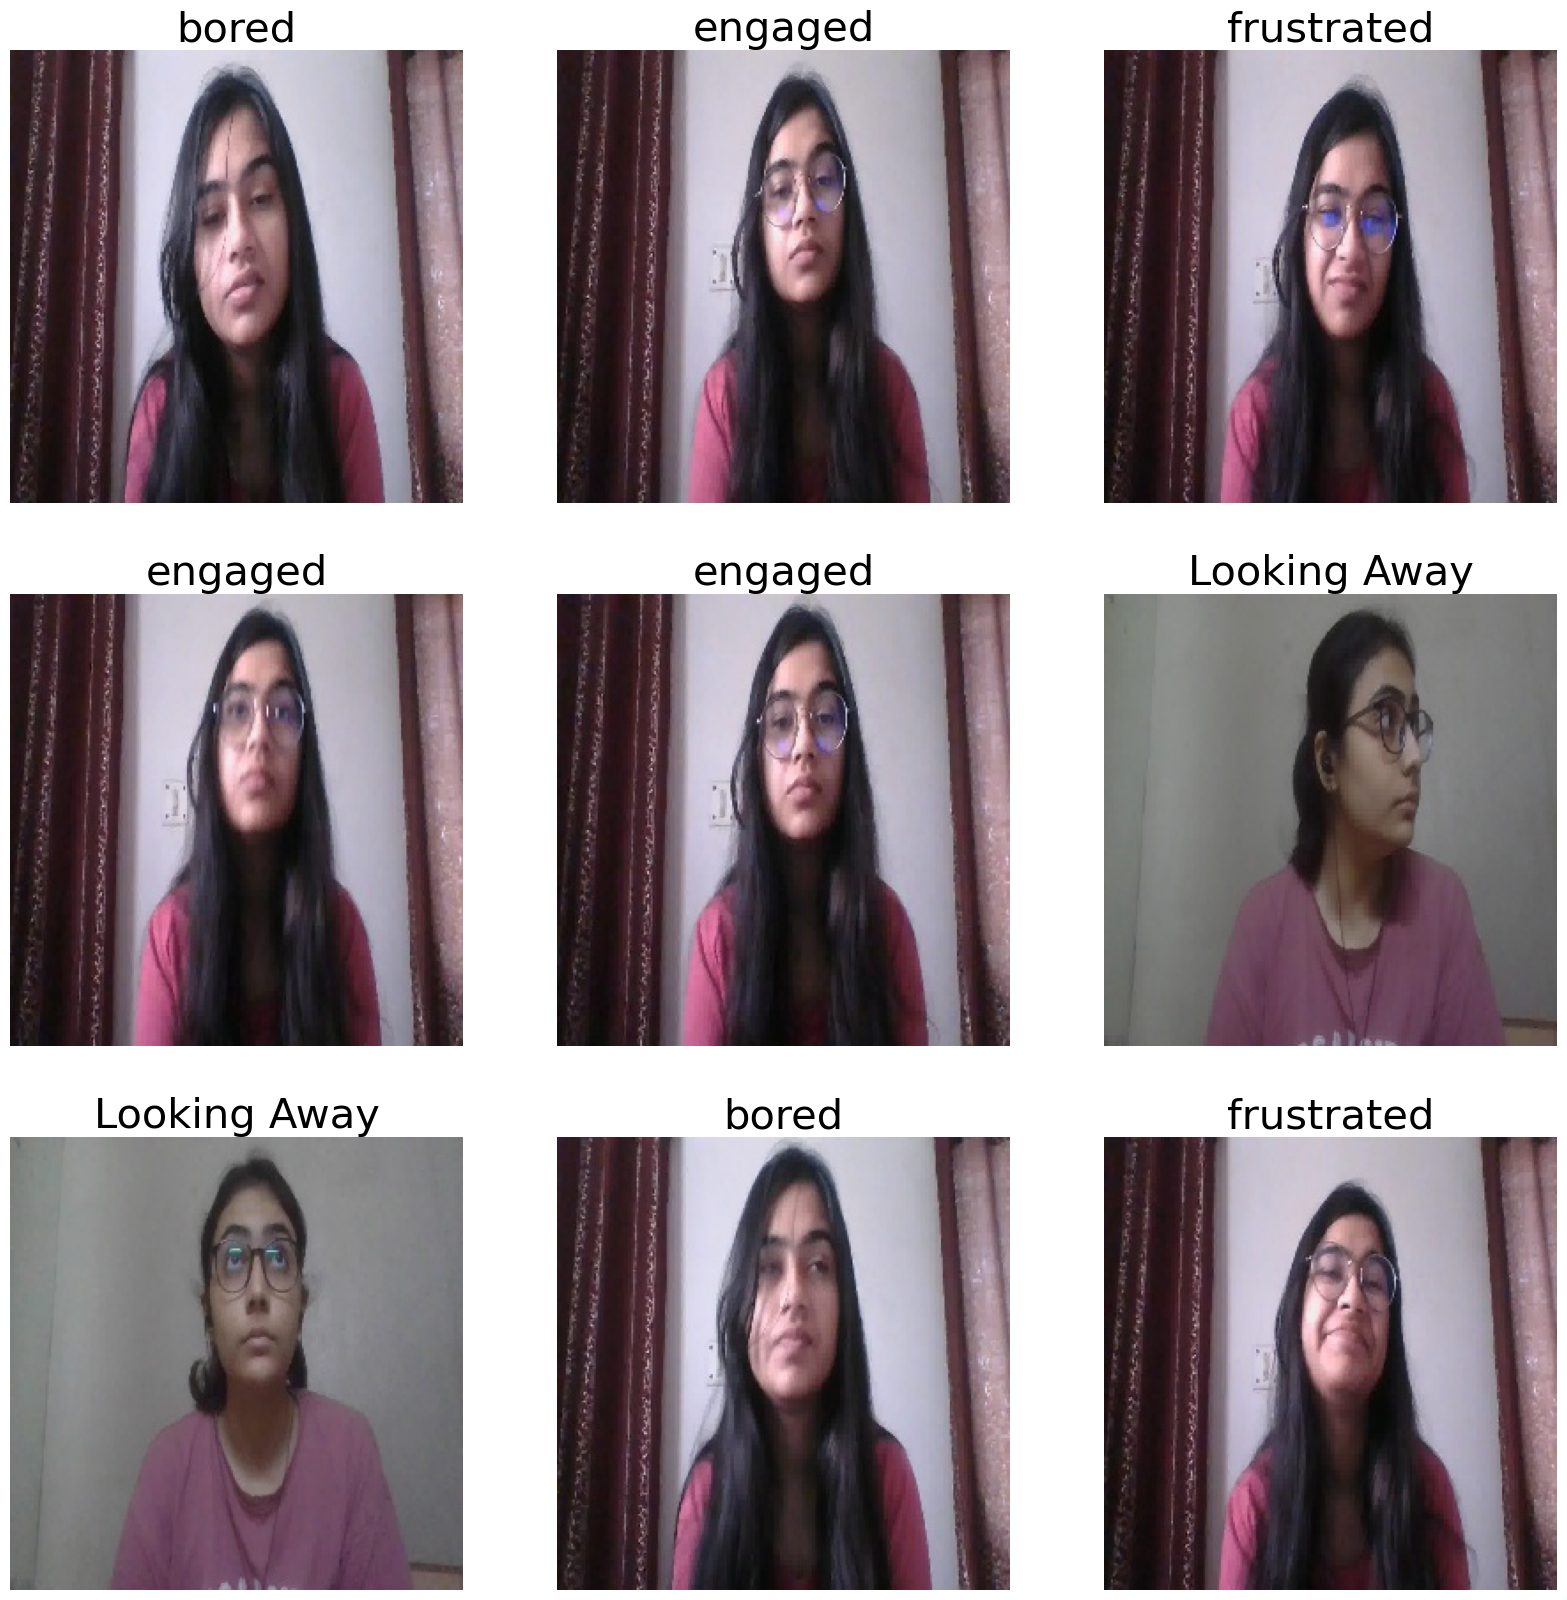

In [ ]:
input_shape = [256,256,3]

# find min_shape
def min_shape(image_paths) : 
    min_shape = [np.inf,np.inf,3]
    for path in image_paths : 
        img  = Image.open(path)
        img = np.array(img)
        for index,shape in enumerate(img.shape) : 
            if img.shape[index] <= min_shape[index]:
                min_shape[index] = img.shape[index]
    return min_shape

# display sample from data after preproccing 
plt.figure(figsize=(20,20))
dataset = pd.DataFrame(zip(dataset['label'] , dataset['preproccesd_image']))
files=dataset.iloc[0:9]
# img=Image.open(img_path)
# plt.imshow(img);
# min_shape= [np.inf,np.inf,3]
for index,label,file_path in files.itertuples():
    #print(index,file_path,label)
    plt.subplot(3,3,index+1)
    img=load_img(file_path)
      
    img=np.array(img)
    plt.imshow(img)
    plt.title(label,fontsize=30)
    plt.axis('off')

### explore test dataset : 

bored
confused
drowsy
engaged
frustrated
Looking Away
2120


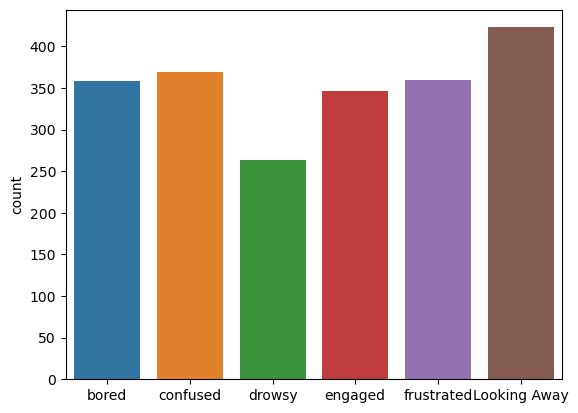

In [ ]:
#number of data in target_test_dir (explore equivlent of data in test part )
image_paths = []
labels_ = []
test_dir_path = "Student-engagement-Dataset/test"

for file in  os.listdir(test_dir_path) : 
    labels = os.path.join(test_dir_path,file)
    print(file)
    for img_name in os.listdir(labels) : 
        img_path = os.path.join(labels,img_name)
        image_paths.append(img_path)
        labels_.append(file)
print(len(labels_))
sns.countplot(x=labels_) ; 

## Explore train Dataset

bored
confused
drowsy
engaged
frustrated
Looking Away
1699


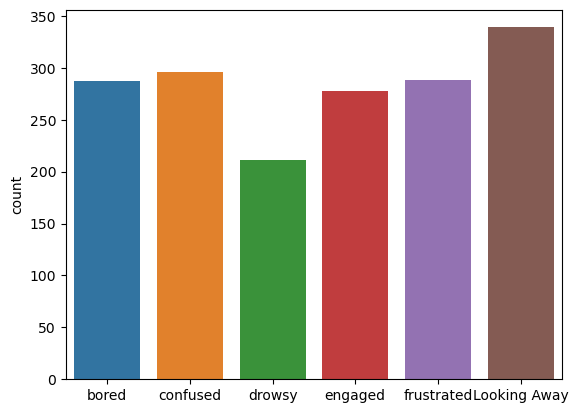

In [ ]:
#train_dir_path =  "/kaggle/working/Student-engagement-Dataset/train"
image_paths=[]
labels_=[]
for file in  os.listdir(Train_dir) : 
    labels = os.path.join(Train_dir,file)
    print(file)
    for img_name in os.listdir(labels) : 
        img_path = os.path.join(labels,img_name)
        image_paths.append(img_path)
        labels_.append(file)
print(len(labels_))

sns.countplot(x=labels_) ;

In [ ]:
from tensorflow.keras.applications import MobileNetV2, Xception, NASNetMobile

In [ ]:
train_path = "Student-engagement-dataset/train"
test_path = "Student-engagement-dataset/test"
val_path = "Student-engagement-dataset/validation"

In [ ]:
IMAGE_SIZE = [256,256]

In [ ]:
# Scaling all the images between 0 to 1

datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

In [ ]:
train_set = datagen.flow_from_directory(train_path,
                                              target_size=(256,256),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = datagen.flow_from_directory(test_path,
                                            target_size=(256,256),
                                            batch_size=2,
                                            class_mode='categorical')

val_set = datagen.flow_from_directory(val_path,
                                            target_size=(256,256),
                                            batch_size=2,
                                            class_mode='categorical')

Found 1699 images belonging to 6 classes.
Found 2120 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

In [ ]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=20,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

# CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(256, 256, 3)))
model1.add(MaxPool2D(strides=2))
model1.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model1.add(MaxPool2D(strides=2))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(84, activation='relu'))
model1.add(Dense(6, activation='softmax'))

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model1.build()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 48)      38448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 48)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 184512)            0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
850/850 [==============================] - 41s 48ms/step - loss: 0.1050 - accuracy: 0.9535 - f1_m: 0.9529 - precision_m: 0.9541 - recall_m: 0.9524 - val_loss: 0.2004 - val_accuracy: 0.9349 - val_f1_m: 0.9352 - val_precision_m: 0.9358 - val_recall_m: 0.9349
Epoch 2/50
850/850 [==============================] - 41s 48ms/step - loss: 0.2904 - accuracy: 0.9459 - f1_m: 0.9447 - precision_m: 0.9471 - recall_m: 0.9435 - val_loss: 0.2183 - val_accuracy: 0.9080 - val_f1_m: 0.9085 - val_precision_m: 0.9104 - val_recall_m: 0.9075
Epoch 3/50
850/850 [==============================] - 41s 49ms/step - loss: 0.0994 - accuracy: 0.9523 - f1_m: 0.9520 - precision_m: 0.9524 - recall_m: 0.9518 - val_loss: 0.2195 - val_accuracy: 0.9274 - val_f1_m: 0.9267 - val_precision_m: 0.9311 - val_recall_m: 0.9245
Epoch 4/50
850/850 [==============================] - 42s 49ms/step - loss: 0.0998 - accuracy: 0.9523 - f1_m: 0.9520 - precision_m: 0.9524 - recall_m: 0.9518 - val_loss: 0.2057 - val_accuracy: 0.9

In [ ]:
dl_acc = hist1.history["val_accuracy"][49]
dl_prec = hist1.history["val_precision_m"][49]
dl_rec =  hist1.history["val_recall_m"][49]
dl_f1 = hist1.history["val_f1_m"][49]

storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

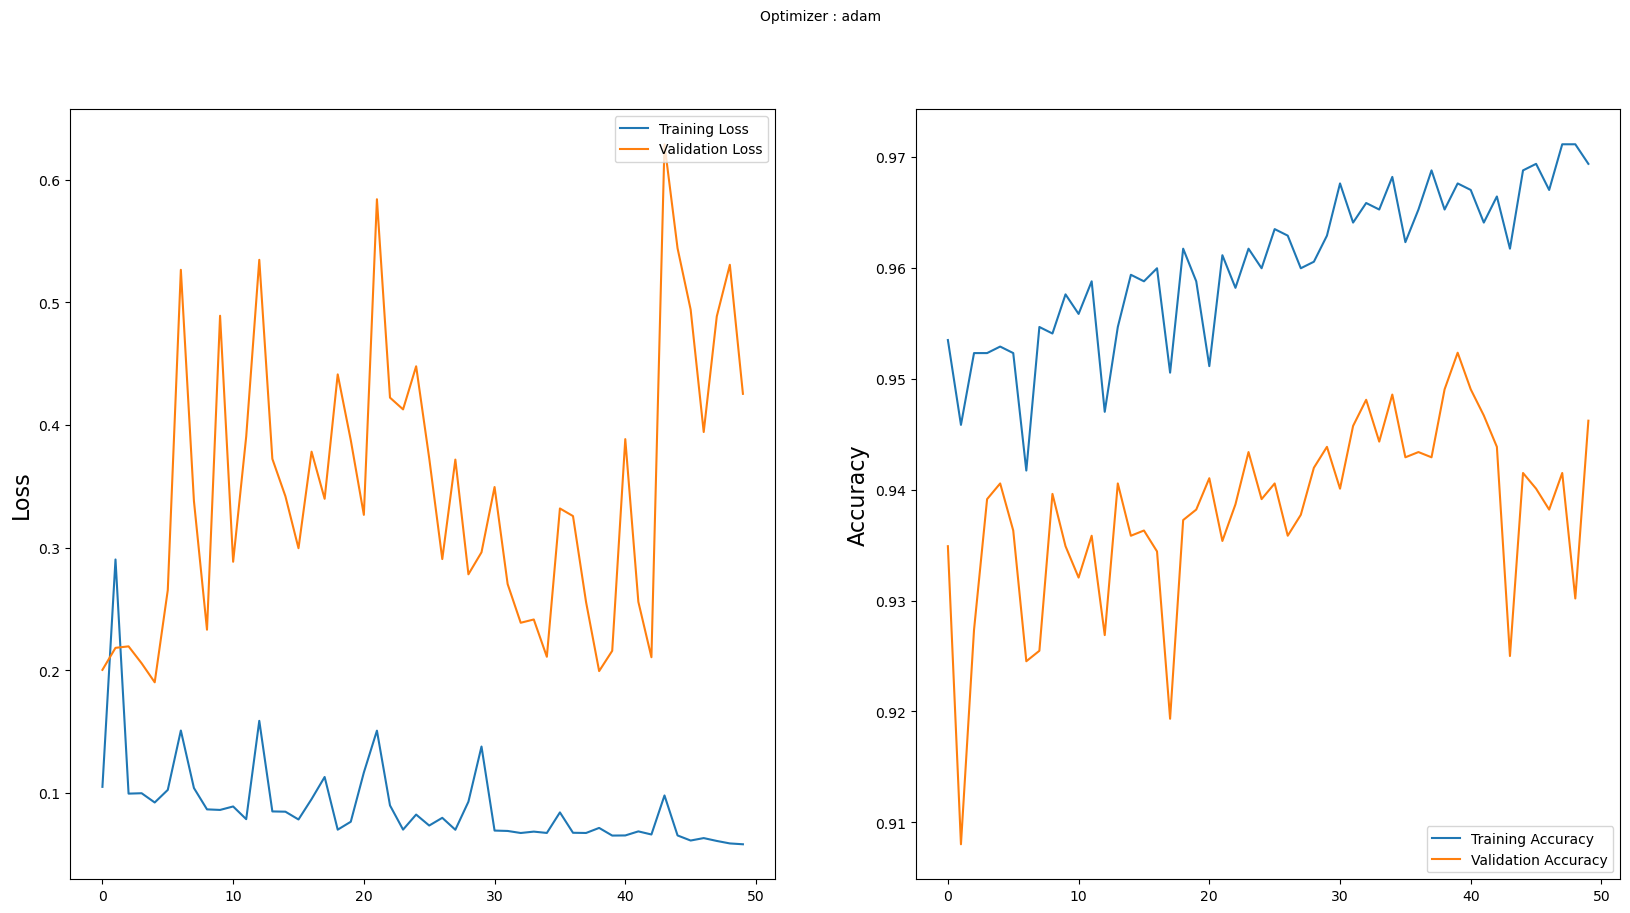

In [ ]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNet

In [ ]:
base_model = MobileNetV2(input_shape = IMAGE_SIZE + [3], weights=None, include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(6, activation='softmax')(x1)
model4 = Model(inputs = base_model.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 64, 64, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 65, 65, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 32, 32, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 32, 32, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 16, 16, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 16, 16, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 16, 16, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 16, 16, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 16, 16, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 16, 16, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 16, 16, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 16, 16, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [ ]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
850/850 [==============================] - 45s 50ms/step - loss: 9.2999 - accuracy: 0.6327 - f1_m: 0.6300 - precision_m: 0.6359 - recall_m: 0.6271 - val_loss: 2.2661 - val_accuracy: 0.1797 - val_f1_m: 0.1802 - val_precision_m: 0.2151 - val_recall_m: 0.1627
Epoch 2/50
850/850 [==============================] - 49s 58ms/step - loss: 0.4325 - accuracy: 0.8952 - f1_m: 0.8935 - precision_m: 0.8971 - recall_m: 0.8918 - val_loss: 3.3847 - val_accuracy: 0.1590 - val_f1_m: 0.1222 - val_precision_m: 0.1288 - val_recall_m: 0.1189
Epoch 3/50
850/850 [==============================] - 42s 49ms/step - loss: 0.2073 - accuracy: 0.9294 - f1_m: 0.9286 - precision_m: 0.9294 - recall_m: 0.9282 - val_loss: 2.4920 - val_accuracy: 0.1689 - val_f1_m: 0.1695 - val_precision_m: 0.1708 - val_recall_m: 0.1689
Epoch 4/50
850/850 [==============================] - 43s 51ms/step - loss: 0.1340 - accuracy: 0.9482 - f1_m: 0.9476 - precision_m: 0.9488 - recall_m: 0.9471 - val_loss: 1.7359 - val_accuracy: 0.2

In [ ]:
dl_acc = hist4.history["val_accuracy"][49]
dl_prec = hist4.history["val_precision_m"][49]
dl_rec =  hist4.history["val_recall_m"][49]
dl_f1 = hist4.history["val_f1_m"][49]

storeResults('MobileNet',dl_acc,dl_prec,dl_rec,dl_f1)

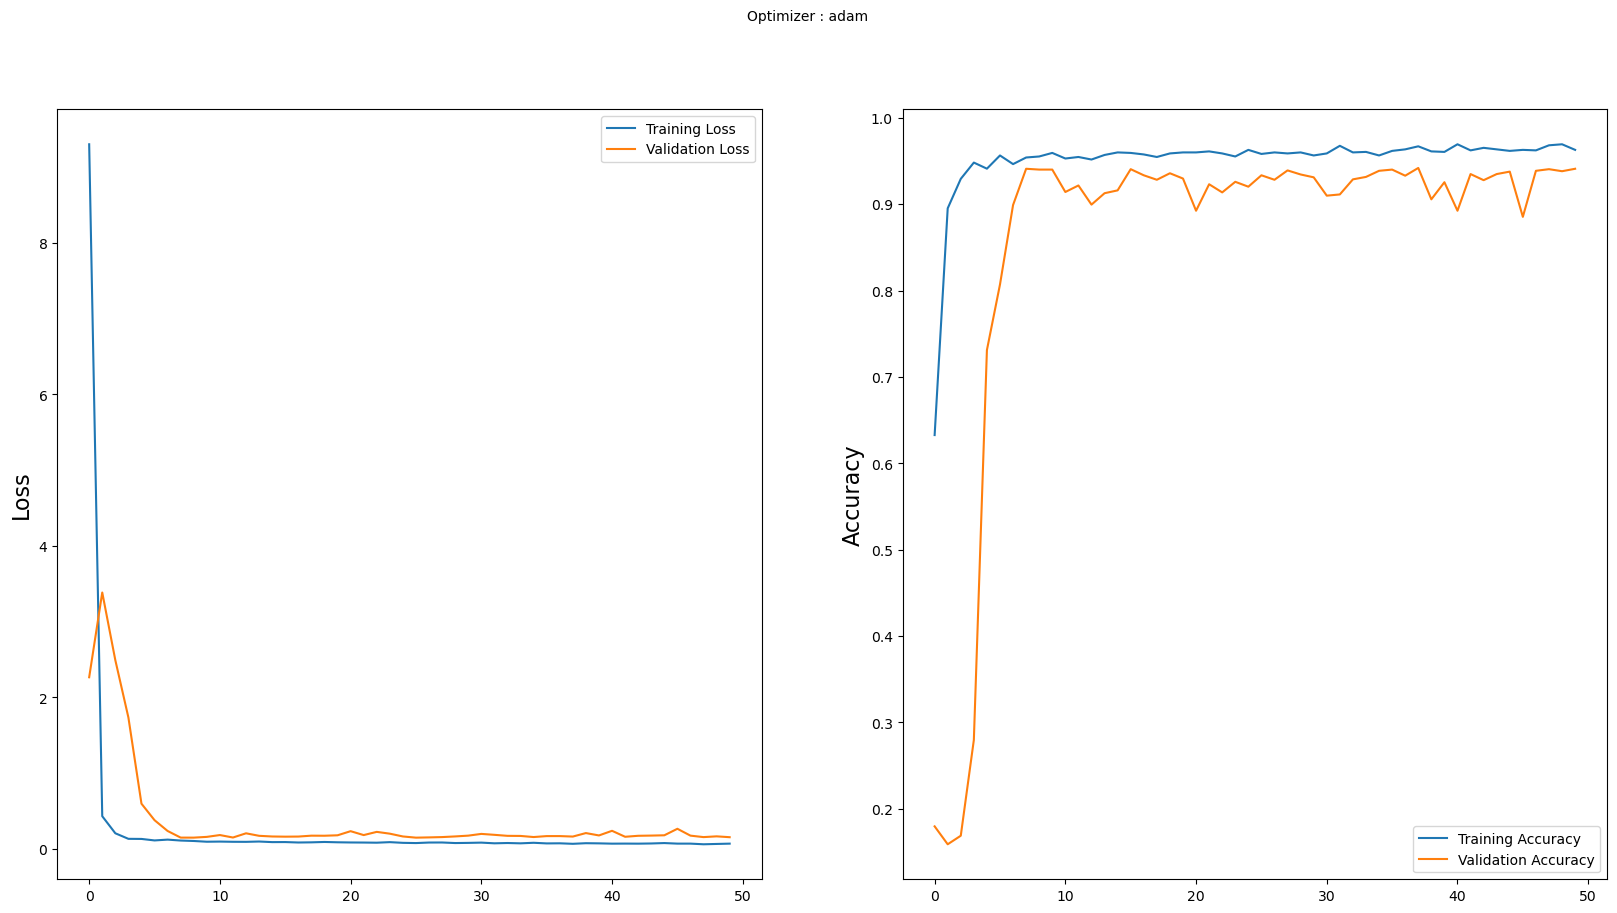

In [ ]:
x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(6, activation='softmax')(x)
# Combining base and head 
model5 = Model(inputs=base.input, outputs=head)

In [ ]:
model5.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [ ]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
850/850 [==============================] - 46s 50ms/step - loss: 0.6399 - accuracy: 0.7905 - f1_m: 0.6796 - precision_m: 0.7294 - recall_m: 0.6547 - val_loss: 0.1900 - val_accuracy: 0.9396 - val_f1_m: 0.9371 - val_precision_m: 0.9425 - val_recall_m: 0.9344
Epoch 2/50
850/850 [==============================] - 43s 50ms/step - loss: 0.1726 - accuracy: 0.9482 - f1_m: 0.9373 - precision_m: 0.9494 - recall_m: 0.9312 - val_loss: 0.1640 - val_accuracy: 0.9594 - val_f1_m: 0.9571 - val_precision_m: 0.9599 - val_recall_m: 0.9557
Epoch 3/50
850/850 [==============================] - 42s 50ms/step - loss: 0.1009 - accuracy: 0.9688 - f1_m: 0.9684 - precision_m: 0.9724 - recall_m: 0.9665 - val_loss: 0.1410 - val_accuracy: 0.9660 - val_f1_m: 0.9662 - val_precision_m: 0.9665 - val_recall_m: 0.9660
Epoch 4/50
850/850 [==============================] - 43s 50ms/step - loss: 0.0692 - accuracy: 0.9788 - f1_m: 0.9786 - precision_m: 0.9794 - recall_m: 0.9782 - val_loss: 0.1316 - val_accuracy: 0.9

In [ ]:
model5.save('xception.h5')

In [ ]:
dl_acc = hist5.history["val_accuracy"][49]
dl_prec = hist5.history["val_precision_m"][49]
dl_rec =  hist5.history["val_recall_m"][49]
dl_f1 = hist5.history["val_f1_m"][49]

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

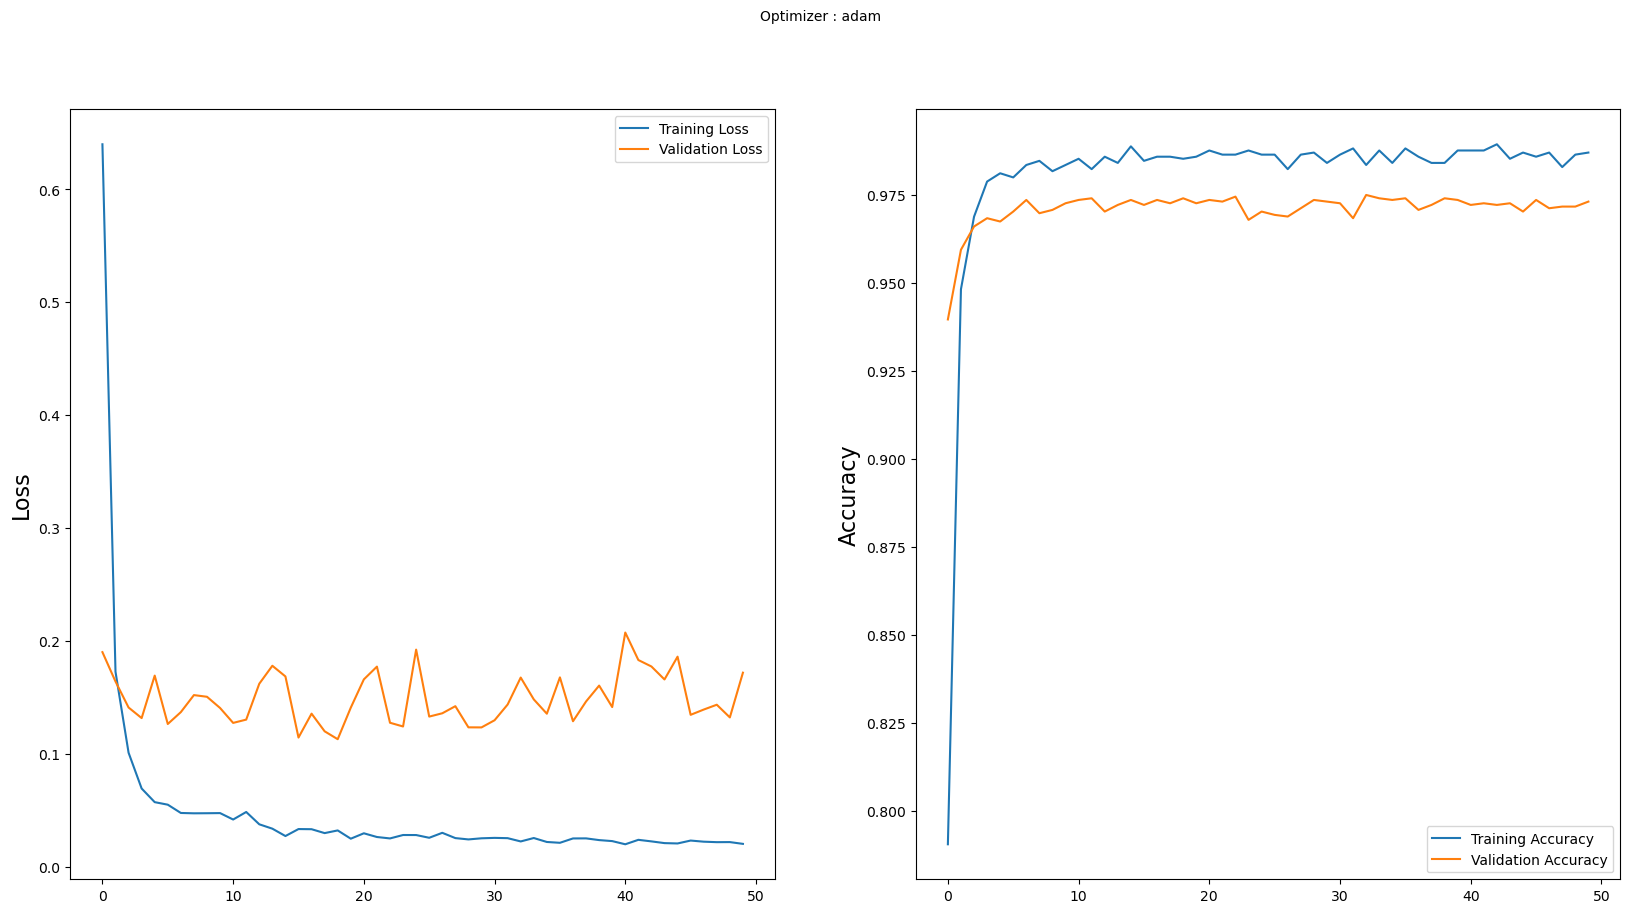

In [ ]:
x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# NASNetMobile

In [ ]:
# Defining the pretrained base model
base = NASNetMobile(include_top=False, weights='imagenet', input_shape=(256,256,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(6, activation='softmax')(x)
# Combining base and head 
model6 = Model(inputs=base.input, outputs=head)

model6.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
model6.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 127, 127, 32  128         ['stem_conv1[0][0]']             
                                )                                                           

                                                                                                  
 separable_conv_1_pad_reduction  (None, 131, 131, 32  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_9 (Activation)      (None, 64, 64, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 64, 64, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add_24 (Add)                   (None, 64, 64, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 64, 64, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 127, 127, 32  0           ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 32, 32, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 69, 69, 22)  0           ['activation_16[0][0]']          
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_18 (Activation)     (None, 64, 64, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 32, 32, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 32, 32, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 32, 32, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 65, 65, 44)  0           ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 32, 32, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 32, 32, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 32, 32, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_24 (Activation)     (None, 32, 32, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 32, 32, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_33 (Activation)     (None, 32, 32, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_34 (Activation)     (None, 32, 32, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 32, 32, 44)  3036        ['activation_40[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 32, 32, 44)  2332        ['activation_42[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 32, 32, 44)  2332        ['activation_44[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 32, 32, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_55 (Activation)     (None, 32, 32, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 32, 32, 44)  3036        ['activation_47[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 32, 32, 44)  2332        ['activation_49[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 32, 32, 44)  3036        ['activation_51[0][0]']          
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 32, 32, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 32, 32, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 32, 32, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_60 (Activation)     (None, 32, 32, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_62 (Activation)     (None, 32, 32, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_64 (Activation)     (None, 32, 32, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_70 (Activation)     (None, 32, 32, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_69 (Activation)     (None, 32, 32, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 32, 32, 88)  23232       ['activation_70[0][0]']          
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 32, 32, 88)  23232       ['activation_69[0][0]']          
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 16, 16, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 16, 16, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 16, 16, 88)  8536        ['activation_79[0][0]']          
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 32, 32, 264)  0           ['zero_padding2d_2[0][0]']       
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 16, 16, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_26[0][0]',                
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_89 (Activation)     (None, 16, 16, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_91 (Activation)     (None, 16, 16, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 16, 16, 88)  9944        ['activation_83[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 16, 16, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 16, 16, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_94 (Activation)     (None, 16, 16, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_96 (Activation)     (None, 16, 16, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 16, 16, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 16, 16, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 16, 16, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 16, 16, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 16, 16, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 16, 16, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 16, 16, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 16, 16, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 16, 16, 88)  9944        ['activation_119[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 16, 16, 88)  8536        ['activation_121[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 16, 16, 88)  9944        ['activation_123[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_130 (Activation)    (None, 16, 16, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_132 (Activation)    (None, 16, 16, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_130[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 21, 21, 176)  0          ['activation_132[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 8, 8, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 17, 17, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 8, 8, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 8, 8, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_140 (Activation)    (None, 8, 8, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 8, 8, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 8, 8, 176)   32560       ['activation_148[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 8, 8, 176)   32560       ['activation_150[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 8, 8, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 8, 8, 176)   35376       ['activation_153[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 8, 8, 176)   32560       ['activation_155[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 8, 8, 176)   35376       ['activation_157[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 8, 8, 176)   32560       ['activation_159[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 8, 8, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 8, 8, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_166 (Activation)    (None, 8, 8, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_168 (Activation)    (None, 8, 8, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_170 (Activation)    (None, 8, 8, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_172 (Activation)    (None, 8, 8, 176)    0           ['separable_conv_1_bn_normal_righ
          

 activation_176 (Activation)    (None, 8, 8, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 8, 8, 176)   185856      ['activation_175[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 8, 8, 176)    185856      ['activation_176[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 8, 8, 176)   704         ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 8, 8, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 8, 8, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 176)   704         ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 8, 8, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (B

In [ ]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
850/850 [==============================] - 145s 154ms/step - loss: 0.3357 - accuracy: 0.8764 - f1_m: 0.8531 - precision_m: 0.8794 - recall_m: 0.8400 - val_loss: 0.4962 - val_accuracy: 0.8373 - val_f1_m: 0.7668 - val_precision_m: 0.8722 - val_recall_m: 0.7142
Epoch 2/50
850/850 [==============================] - 125s 147ms/step - loss: 0.0966 - accuracy: 0.9606 - f1_m: 0.9602 - precision_m: 0.9618 - recall_m: 0.9594 - val_loss: 0.1794 - val_accuracy: 0.9410 - val_f1_m: 0.9387 - val_precision_m: 0.9462 - val_recall_m: 0.9349
Epoch 3/50
850/850 [==============================] - 122s 144ms/step - loss: 0.0720 - accuracy: 0.9770 - f1_m: 0.9771 - precision_m: 0.9771 - recall_m: 0.9771 - val_loss: 0.1893 - val_accuracy: 0.9519 - val_f1_m: 0.9498 - val_precision_m: 0.9561 - val_recall_m: 0.9467
Epoch 4/50
850/850 [==============================] - 124s 146ms/step - loss: 0.0594 - accuracy: 0.9800 - f1_m: 0.9798 - precision_m: 0.9818 - recall_m: 0.9788 - val_loss: 0.4445 - val_accur

In [ ]:
model6.save('nasnet.h5')

In [ ]:
dl_acc = hist6.history["val_accuracy"][49]
dl_prec = hist6.history["val_precision_m"][49]
dl_rec =  hist6.history["val_recall_m"][49]
dl_f1 = hist6.history["val_f1_m"][49]

storeResults('NASNetMobile',dl_acc,dl_prec,dl_rec,dl_f1)

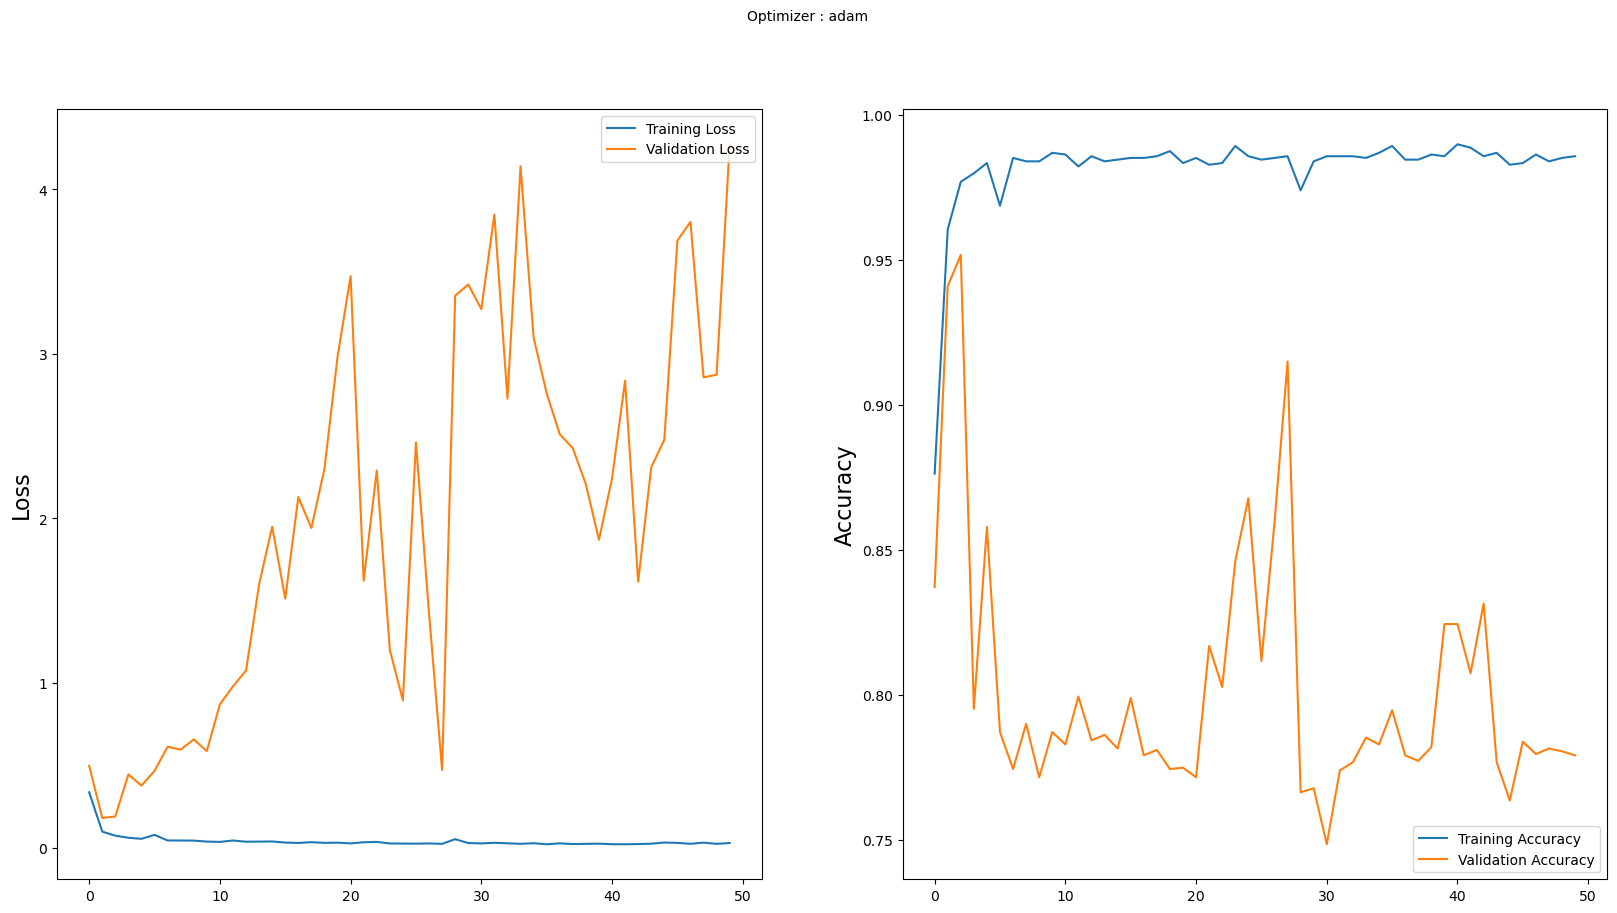

In [ ]:
x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Ensemble Model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras

In [ ]:
def ensemble():

    model_1 = load_model('xception.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('nasnet.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'NASNetMobile')
    
    models = [model_1, model_2]


    models_input = Input(shape =(256,256,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Extension')

    return simple_average

In [ ]:
ext = ensemble()
ext.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
ext.summary()

Model: "Extension"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Xception (Functional)          (None, 6)            20873774    ['input_1[0][0]']                
                                                                                                  
 NASNetMobile (Functional)      (None, 6)            4276058     ['input_1[0][0]']                
                                                                                                  
 average (Average)              (None, 6)            0           ['Xception[0][0]',       

In [ ]:
history1 = ext.fit(train_set, epochs=50, validation_data=test_set,steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
850/850 [==============================] - 146s 172ms/step - loss: 0.0224 - accuracy: 0.9871 - f1_m: 0.9871 - precision_m: 0.9871 - recall_m: 0.9871 - val_loss: 0.2347 - val_accuracy: 0.9745 - val_f1_m: 0.8542 - val_precision_m: 0.9467 - val_recall_m: 0.8080 - lr: 0.0100
Epoch 2/50
850/850 [==============================] - 141s 166ms/step - loss: 0.0203 - accuracy: 0.9853 - f1_m: 0.9857 - precision_m: 0.9865 - recall_m: 0.9853 - val_loss: 0.2302 - val_accuracy: 0.9750 - val_f1_m: 0.8807 - val_precision_m: 0.9618 - val_recall_m: 0.8401 - lr: 0.0100
Epoch 3/50
850/850 [==============================] - 142s 167ms/step - loss: 0.0197 - accuracy: 0.9859 - f1_m: 0.9859 - precision_m: 0.9859 - recall_m: 0.9859 - val_loss: 0.2442 - val_accuracy: 0.9755 - val_f1_m: 0.8642 - val_precision_m: 0.9462 - val_recall_m: 0.8231 - lr: 0.0100
Epoch 4/50
850/850 [==============================] - 144s 170ms/step - loss: 0.0197 - accuracy: 0.9865 - f1_m: 0.9861 - precision_m: 0.9865 - recall_m

In [ ]:
dl_acc = history1.history["val_accuracy"][27]
dl_prec = history1.history["val_precision_m"][27]
dl_rec =  history1.history["val_recall_m"][27]
dl_f1 = history1.history["val_f1_m"][27]

storeResults('Xception+NASNetMobile',dl_acc,dl_prec,dl_rec,dl_f1)

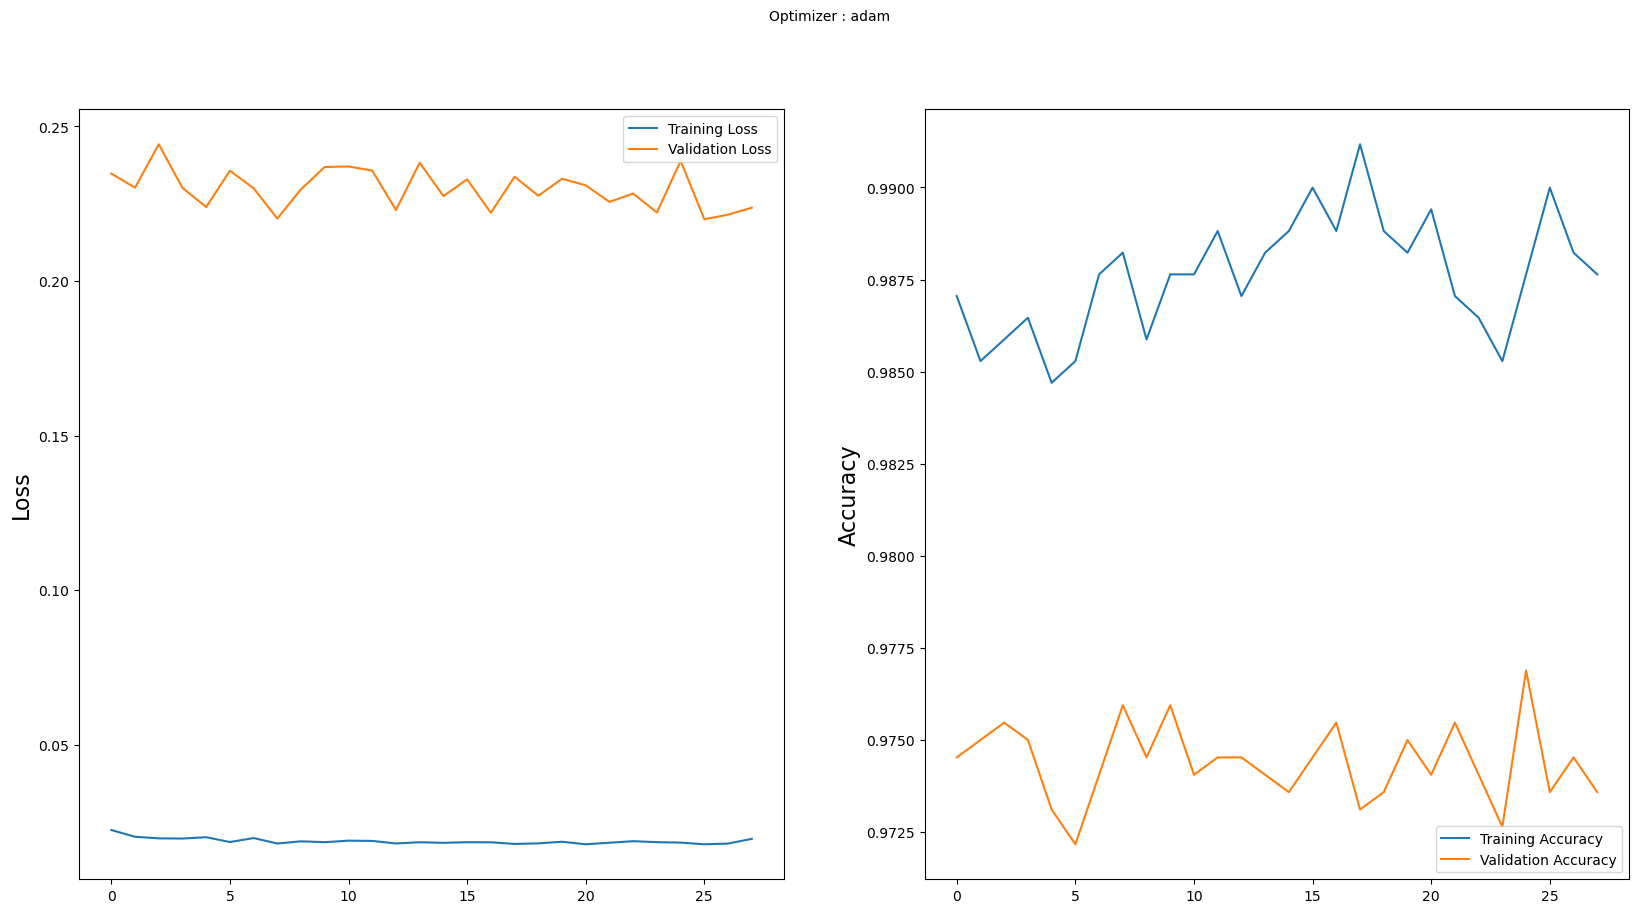

In [ ]:
x=history1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [ ]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        
                      })

In [ ]:
result

ML Model  Accuracy  Precision  Recall  F1-Score
0                    CNN     0.946      0.947   0.946     0.946
1              MobileNet     0.941      0.944   0.937     0.940
2               Xception     0.973      0.973   0.973     0.973
3           NASNetMobile     0.779      0.779   0.779     0.779
4  Xception+NASNetMobile     0.974      0.968   0.909     0.929

# Modelling

In [ ]:
ext.save('ensemble.h5')

# Graph

In [ ]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

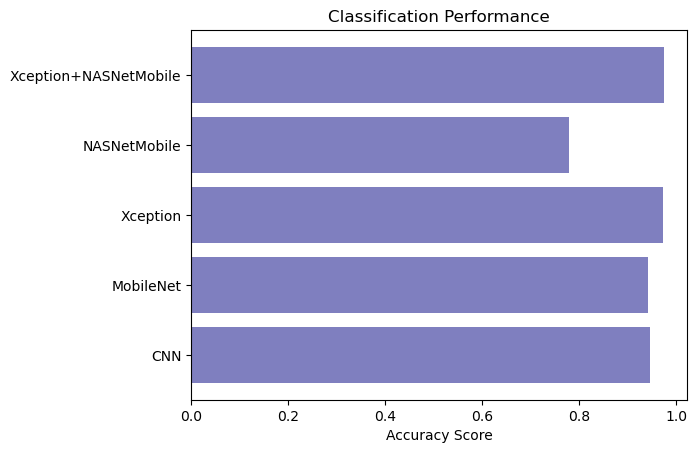

In [ ]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

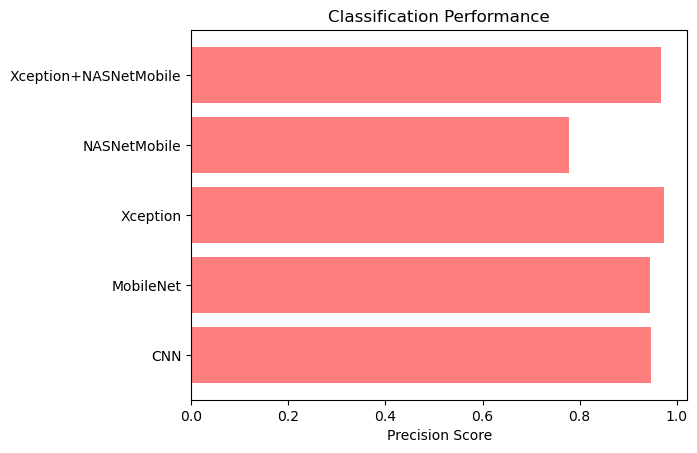

In [ ]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

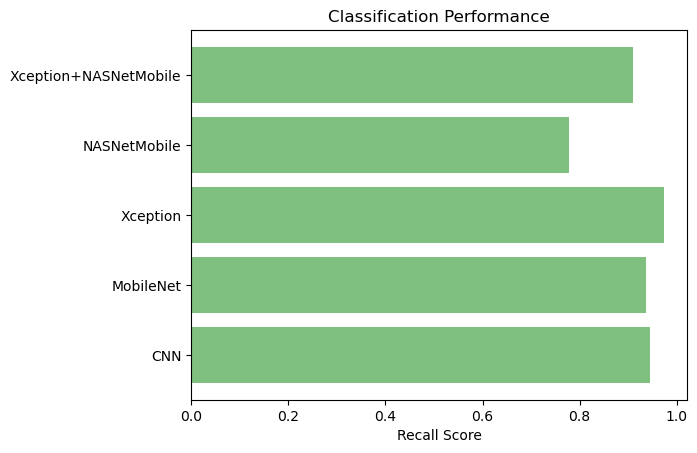

In [ ]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

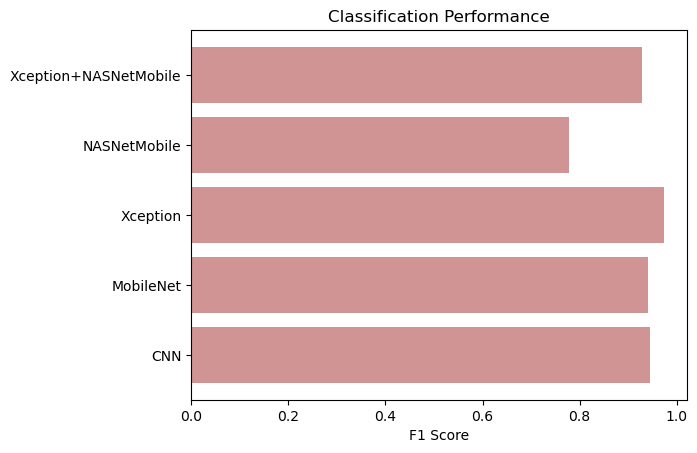

In [ ]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='brown')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()